# Solve the latent variable Gaussian Graphical model using cvxpy

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from time import gmtime, strftime
import scipy as sp
import cvxpy as cvx
from sklearn.linear_model import lars_path
%matplotlib inline 
import sys
sys.path.append('/home/tianpei/Dropbox/Codes/Python/LatNet/src/')

In [2]:
from latent_signal_network import latent_signal_network as lsn 

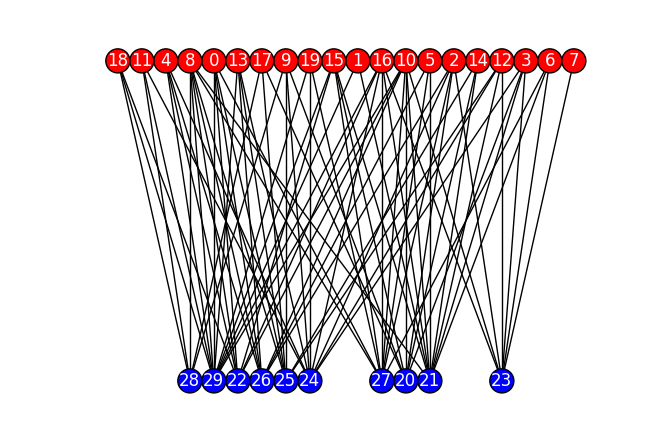

In [3]:
savefigure = False
seed = 1000
choice = 'bipartite_binomial'
d = 12
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'partition':
    size = [20, 20]
    prob = [0.8, 0.1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'grid':
    size = [5, 5]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18

    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': choice}
    option['cutoff_freq'] = 10
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
    
elif choice == 'balanced_tree':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['r'] = 2
    option['h'] = 3
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)  
    
elif choice == 'bipartite_binomial':
    size = [20, 10]
    prob = 0.4
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)  
    
elif choice == 'bipartite_uniform':
    size = [20, 20]
    prob = 0.17
    num_edges = prob*size[0]*size[1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['num_edges'] = num_edges
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)     

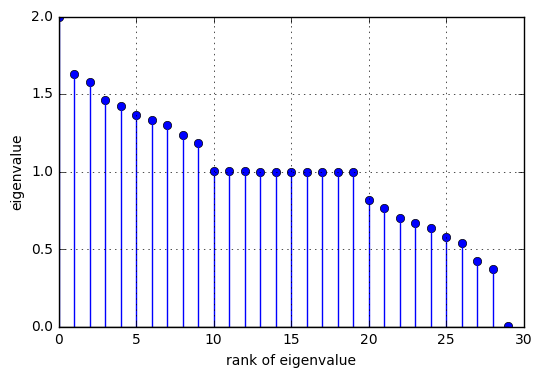

In [4]:
#Plot the eigenvalue of Laplacian matrix
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
#Sigma, U = np.linalg.eigh(abs(adjMat))
Sigma, U = np.linalg.eigh(Laplacian)

index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_laplacian.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

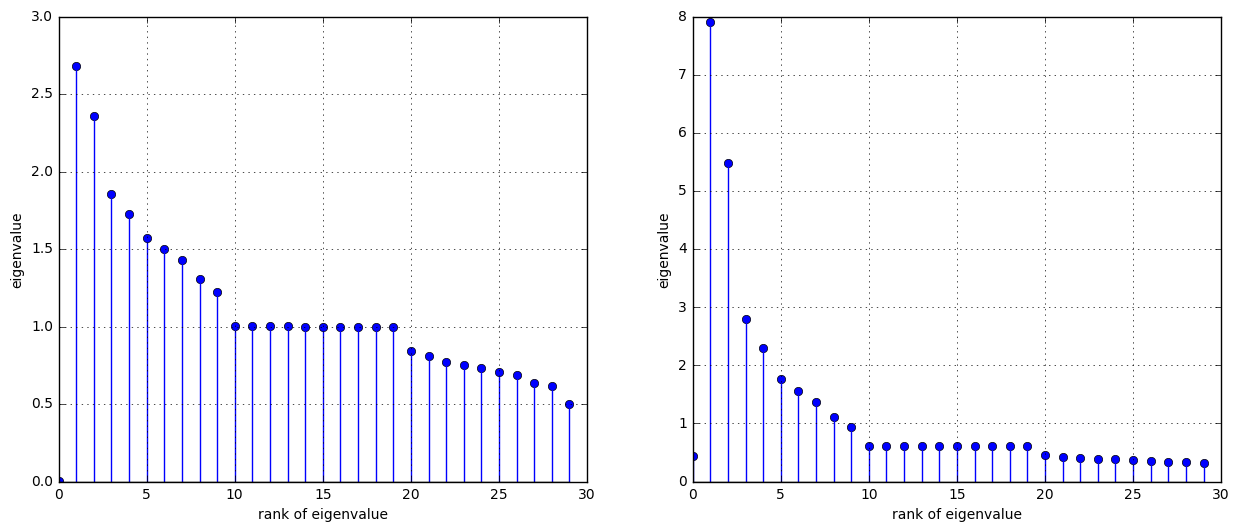

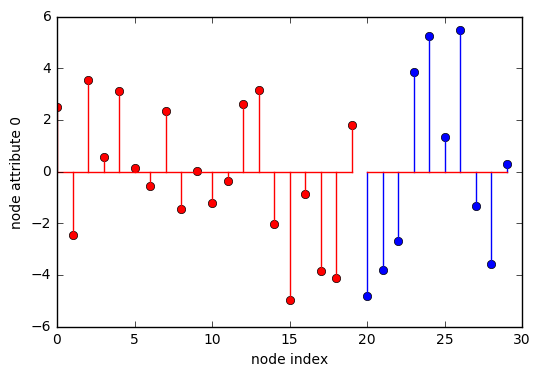

In [5]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'laplacian_matrix' #'adjacency_matrix'
choice2 = 'polynomial'

if choice2 == 'l1_threshold':
    option_sig['method'] = choice2
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    option_sig['method'] = choice2
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1/2, 1/3, 1/3]
elif choice2 == 'rescale':
    option_sig['method'] = choice2
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid_theshold':
    option_sig['method'] = choice2
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
    
     
    
G0_node, X0, _= LSN.smooth_gsignal_filter(G0, option_sig, sigma=10, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)
#G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=10, alpha=0.2, seed=10, add_noise=False, overwrite=True)
fig1 = plt.figure(1)
if 'bipartite' in choice:
    node_sets = bipartite.sets(G0)
    (markerline, stemlines, baseline) = plt.stem(np.arange(len(node_sets[0])),X0[0:len(node_sets[0]),0], 'r')
    plt.setp(markerline, 'markerfacecolor', 'r')
    (markerline, stemlines, baseline) = plt.stem(len(node_sets[0])+np.arange(len(node_sets[1])),X0[len(node_sets[0]):len(G0),0], 'b')
    plt.setp(markerline, 'markerfacecolor', 'b')
else:    
    (markerline, stemlines, baseline) = plt.stem(np.arange(X0.shape[0]),X0[:,0])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

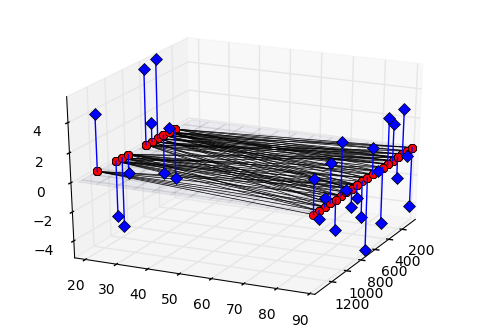

In [6]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
elif 'bipartite' in choice:
    pos=nx.nx_pydot.graphviz_layout(G0, prog='dot')
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
X0_2, nodeIdx = LSN.get_node_attributes(G0_node)
pos_coordinate = np.array([[pos[it['node']][0], pos[it['node']][1]] for it in nodeIdx])

edge_list = LSN.get_edgelist(G0_node)

view_angle = [25, 25] #[25, 180]
LSN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

In [7]:
node_sets = bipartite.sets(G0)
node_lists = [list(node_sets[0]), list(node_sets[1])]
observed_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[0]]
hidden_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[1]]

##  Use cvx to learn the latent variable sparse inverse covariance estimation

\begin{eqnarray}
 (\mathbf{S}^{*} , \mathbf{L}^{*})&= \arg\min_{\mathbf{L}\;, \;\mathbf{S}} -\frac{m}{2}\log\det\left(\mathbf{S} - \mathbf{L}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{o}\left( \mathbf{S} - \mathbf{L}\right)\right) + \alpha_{m} \left(\lambda \|\mathbf{S}\|_{1}  + \|\mathbf{L}\|_{*}\right)  \\
&\phantom{=}\text{s.t. }\quad \mathbf{S} - \mathbf{L}\succeq \mathbf{0} \nonumber\\
&\phantom{===}\; \mathbf{L}\succeq \mathbf{0}  \nonumber
\end{eqnarray}

In [8]:
X_o = X0[observed_idx,:]
n, m = X_o.shape
emp_cov = np.cov(X_o)
alpha = 0.5
lambda_s = 1
    
costs = list()
covariance_o = emp_cov.copy()

    # As a trivial regularization (Tikhonov like), we scale down the
    # off-diagonal coefficients of our starting point: This is needed, as
    # in the cross-validation the cov_init can easily be
    # ill-conditioned, and the CV loop blows. Beside, this takes
    # conservative stand-point on the initial conditions, and it tends to
    # make the convergence go faster.

covariance_o *= 0.95
diagonal_o = emp_cov.flat[::n+1]
covariance_o.flat[::n+1] = diagonal_o
    

In [9]:
# define the low-rank term L and sparse term S
L = cvx.Semidef(n)
S = cvx.Symmetric(n)
# define the SDP problem 
objective = cvx.Minimize(- cvx.log_det(S-L) + cvx.trace(covariance_o*(S-L)) + alpha*lambda_s*cvx.norm(S,1) + alpha*cvx.norm(L, "nuc")  )
constraints = [S-L >> 0]
  
# solve the problem
problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -6.9315e+00  1e+03  1e+00  1e+00
 1: -1.6622e+02 -1.9982e+02  1e+03  1e+00  1e+00
 2: -1.1139e+02 -2.9190e+02  9e+02  8e-01  8e-01
 3: -2.8246e+00 -3.2095e+02  8e+02  6e-01  6e-01
 4:  2.0016e+02 -1.8996e+02  6e+02  3e-01  3e-01
 5:  2.4065e+02 -3.5354e+01  3e+02  9e-02  8e-02
 6:  1.8448e+02  1.6807e+01  2e+02  3e-02  3e-02
 7:  1.3832e+02  3.1481e+01  1e+02  1e-02  1e-02
 8:  8.1381e+01  3.8904e+01  5e+01  5e-03  6e-03
 9:  6.8547e+01  4.0908e+01  3e+01  3e-03  4e-03
10:  5.3168e+01  4.3169e+01  1e+01  1e-03  2e-03
11:  5.1441e+01  4.3613e+01  8e+00  8e-04  1e-03
12:  5.0182e+01  4.3853e+01  6e+00  3e-04  7e-04
13:  4.8832e+01  4.4086e+01  5e+00  1e-04  4e-04
14:  4.6655e+01  4.4371e+01  2e+00  8e-05  3e-04
15:  4.6463e+01  4.4398e+01  2e+00  6e-05  3e-04
16:  4.5524e+01  4.4514e+01  1e+00  2e-05  1e-04
17:  4.5349e+01  4.4536e+01  8e-01  1e-05  1e-04
18:  4.4900e+01  4.4588e+01  3e-01  3e-06  6e-05
19:  4.4772e+01  4.46

44.61967031424409

In [10]:
L_res = L.value
S_res = S.value
precision_cvx = S_res - L_res

In [11]:
np.linalg.norm(L_res -L_res.T)


0.0

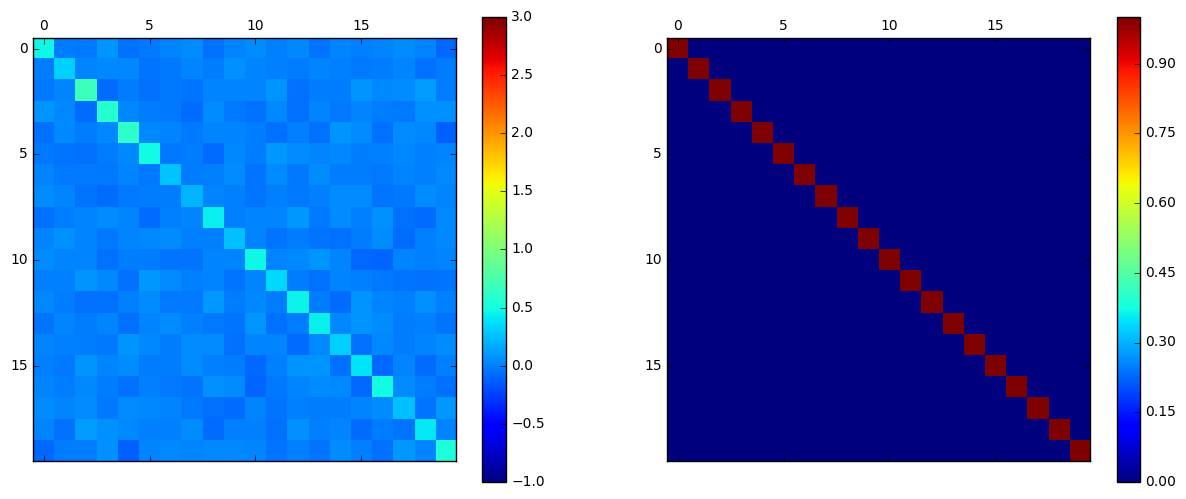

In [12]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision_cvx, vmin=-1, vmax=3)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(Laplacian[np.ix_(node_lists[0], node_lists[0])])
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

In [13]:
from Gaussian_network import latent_variable_glasso_random, latent_variable_glasso_data

In [14]:
covariance_o, precision_o, _, prec_all_list = latent_variable_glasso_random(X_o, h_dim=len(node_sets[1]), alpha=alpha, max_iter_out = 8, max_iter_in=100, return_hists=True)

The algorithm did not coverge. Try increasing the max number of iterations.
The algorithm did not coverge. Try increasing the max number of iterations.


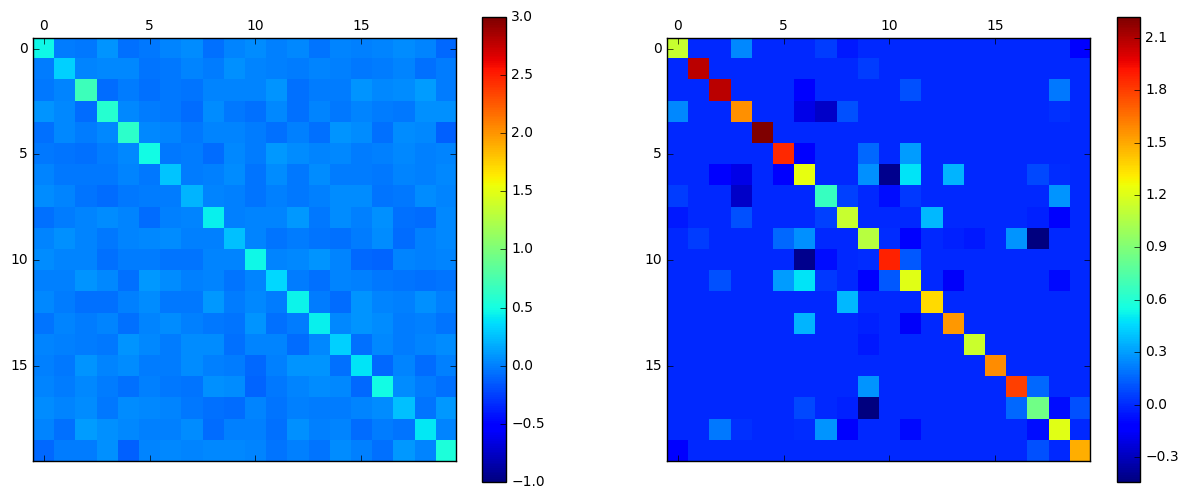

In [15]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision_cvx, vmin=-1, vmax=3)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(precision_o)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)